In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns

In [2]:
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

In [3]:
# Rename label into Label
train_df.rename(columns={'label':'Label'},inplace = True)
test_df.rename(columns={'label':'Label'},inplace = True)

# Shuffle
train_df = train_df.sample(frac = 1.0).reset_index(drop = True)
test_df = test_df.sample(frac = 1.0).reset_index(drop = True)

In [4]:
# Show the first lines
train_df.iloc[:4,:10]

,Label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9
0,20,100,103,105,108,111,114,116,118,120
1,7,150,157,164,169,172,174,175,178,180
2,10,89,92,95,98,99,103,106,108,109
3,18,92,99,101,103,107,113,118,121,125


In [5]:
printmd(f'### Number of images in the training set: {train_df.shape[0]}')
printmd(f'### Number of images in the test set: {test_df.shape[0]}')

d = int((train_df.shape[1] - 1)**0.5)
printmd(f'### Shape of the images: {d} x {d}')

### Number of images in the training set: 27455

### Number of images in the test set: 7172

### Shape of the images: 28 x 28

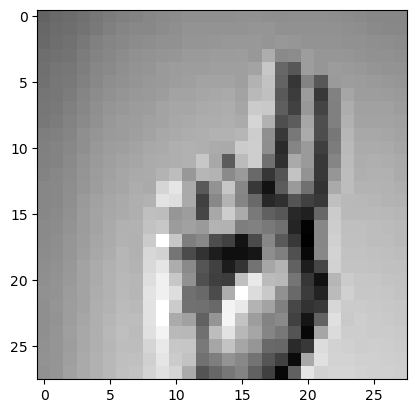

In [6]:
def to_image(array, label = True):
    # Reshape an array into an image format
    array = np.array(array)
    start_idx = 1 if label else 0
    return array[start_idx:].reshape(28,28).astype(float)
        
# Display one image
img = to_image(train_df.iloc[0])
plt.imshow(img, cmap = 'gray')
plt.show()

In [7]:
# The labels are coded in numbers. 
# Create a mapping to get the letters corresponding to the numbers
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {}

for i,l in enumerate(alphab):
    mapping_letter[l] = i
mapping_letter = {v:k for k,v in mapping_letter.items()}

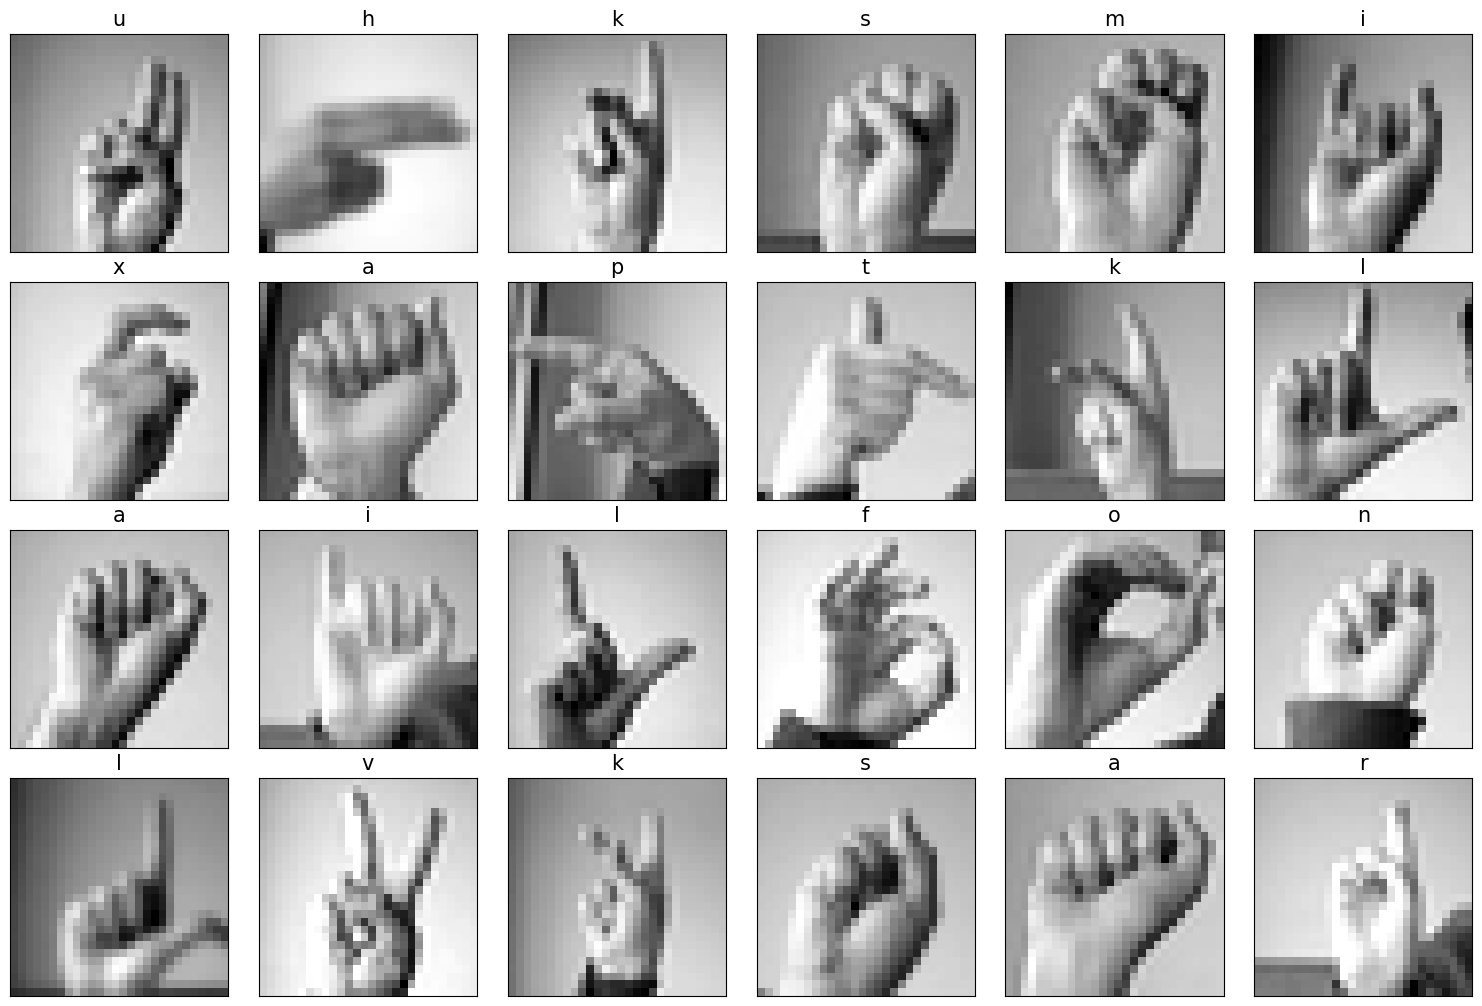

In [8]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = to_image(train_df.iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = mapping_letter[train_df.Label[i]]
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


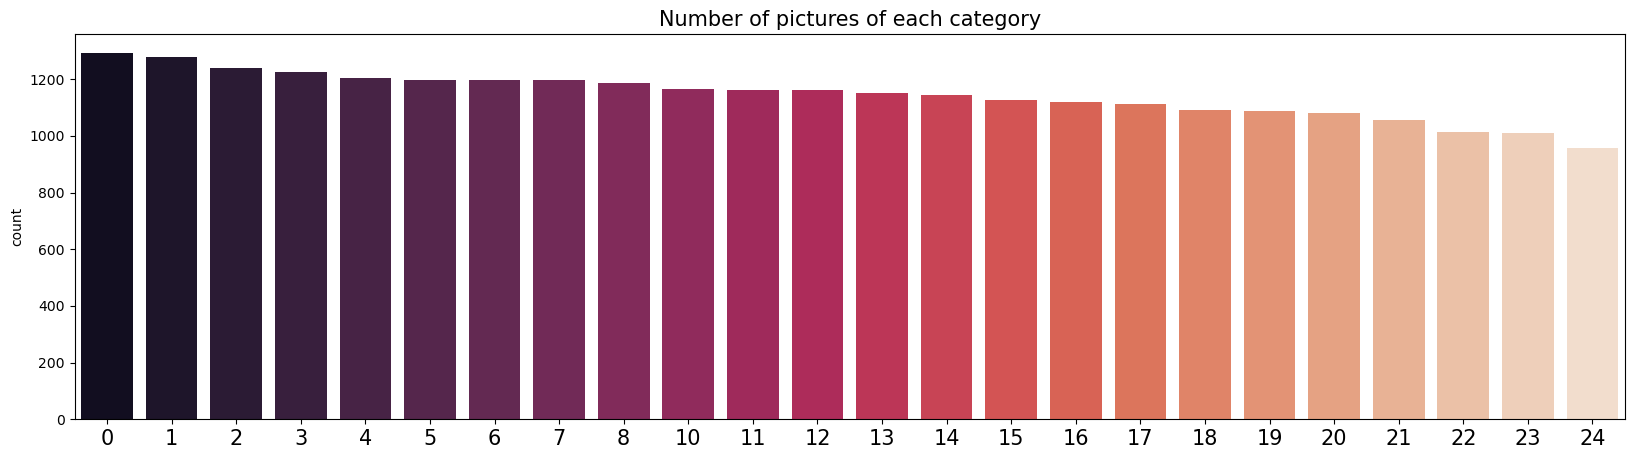

In [9]:
# Display the number of pictures of each letter
vc = train_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

# 2. Split the data and create the generator<a class="anchor" id="2"></a>

In [10]:
train_df_original = train_df.copy()

# Split into training, test and validation sets
val_index = int(train_df.shape[0]*0.1)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

y_train = train_df['Label']
y_val = val_df['Label']
y_test = test_df['Label']

# Reshape the traing and test set to use them with a generator
X_train = train_df.drop('Label',axis = 1).values.reshape(train_df.shape[0], 28, 28, 1)
X_val = val_df.drop('Label',axis = 1).values.reshape(val_df.shape[0], 28, 28, 1)
X_test = test_df.drop('Label',axis = 1).values.reshape(test_df.shape[0], 28, 28, 1)

In [11]:
# Display the shapes of the sets
X_train.shape, X_val.shape, X_test.shape

((24710, 28, 28, 1), (2745, 28, 28, 1), (7172, 28, 28, 1))

In [12]:
# Data augmentation
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")

X_train_flow = generator.flow(X_train, y_train, batch_size=32)
X_val_flow = generator.flow(X_val, y_val, batch_size=32)
# X_test_flow = generator.flow(X_test, y_test)

# 3. Create and train the model <a class="anchor" id="3"></a>

In [13]:
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Flatten(),
                    
                    Dense(units=1024, activation="relu"),                 
                    Dense(units=256, activation="relu"),
                    Dropout(0.5),
                    Dense(units=25, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         590336    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 512)         0

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow, 
                    validation_data=X_val_flow, 
                    epochs=100,
                    callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True), 
                        
                            learning_rate_reduction
                    ])

Epoch 1/100
773/773 [==============================] - 29s 37ms/step - loss: 1.6737 - accuracy: 0.4613 - val_loss: 0.3512 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 2/100
773/773 [==============================] - 29s 37ms/step - loss: 0.3195 - accuracy: 0.8906 - val_loss: 0.1377 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 3/100
773/773 [==============================] - 28s 37ms/step - loss: 0.1380 - accuracy: 0.9541 - val_loss: 0.0514 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 4/100
773/773 [==============================] - 27s 35ms/step - loss: 0.0787 - accuracy: 0.9756 - val_loss: 0.0345 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 5/100
773/773 [==============================] - 30s 38ms/step - loss: 0.0644 - accuracy: 0.9796 - val_loss: 0.0309 - val_accuracy: 0.9909 - lr: 0.0010
Epoch 6/100
773/773 [==============================] - 29s 38ms/step - loss: 0.0522 - accuracy: 0.9846 - val_loss: 0.0349 - val_accuracy: 0.9913 - lr: 0.0010
Epoch 7/100
773/773 [==============================]

# 4. Visualize the result <a class="anchor" id="4"></a>

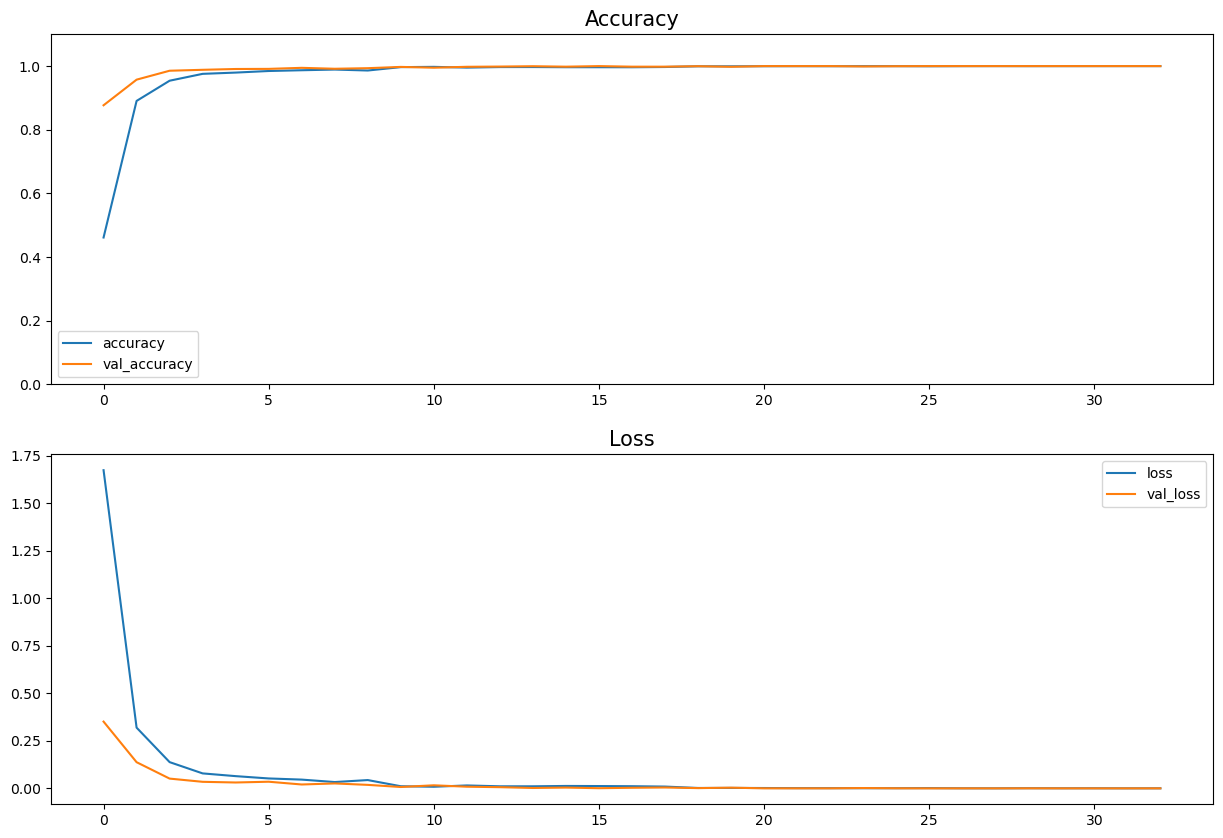

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [16]:
# Predict the label of the test_images
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## {acc*100:.2f}% accuracy on the test set')

225/225 [==============================] - 2s 9ms/step


## 99.51% accuracy on the test set

In [17]:
# Map the numbers into letters
y_test_letters = [mapping_letter[x] for x in y_test]
pred_letters = [mapping_letter[x] for x in pred]

In [18]:
print(classification_report(y_test_letters,pred_letters))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00       331
           b       1.00      1.00      1.00       432
           c       1.00      1.00      1.00       310
           d       1.00      1.00      1.00       245
           e       1.00      1.00      1.00       498
           f       1.00      1.00      1.00       247
           g       1.00      1.00      1.00       348
           h       1.00      1.00      1.00       436
           i       1.00      1.00      1.00       288
           k       1.00      1.00      1.00       331
           l       1.00      1.00      1.00       209
           m       1.00      1.00      1.00       394
           n       1.00      1.00      1.00       291
           o       1.00      1.00      1.00       246
           p       1.00      1.00      1.00       347
           q       1.00      1.00      1.00       164
           r       1.00      1.00      1.00       144
           s       1.00    

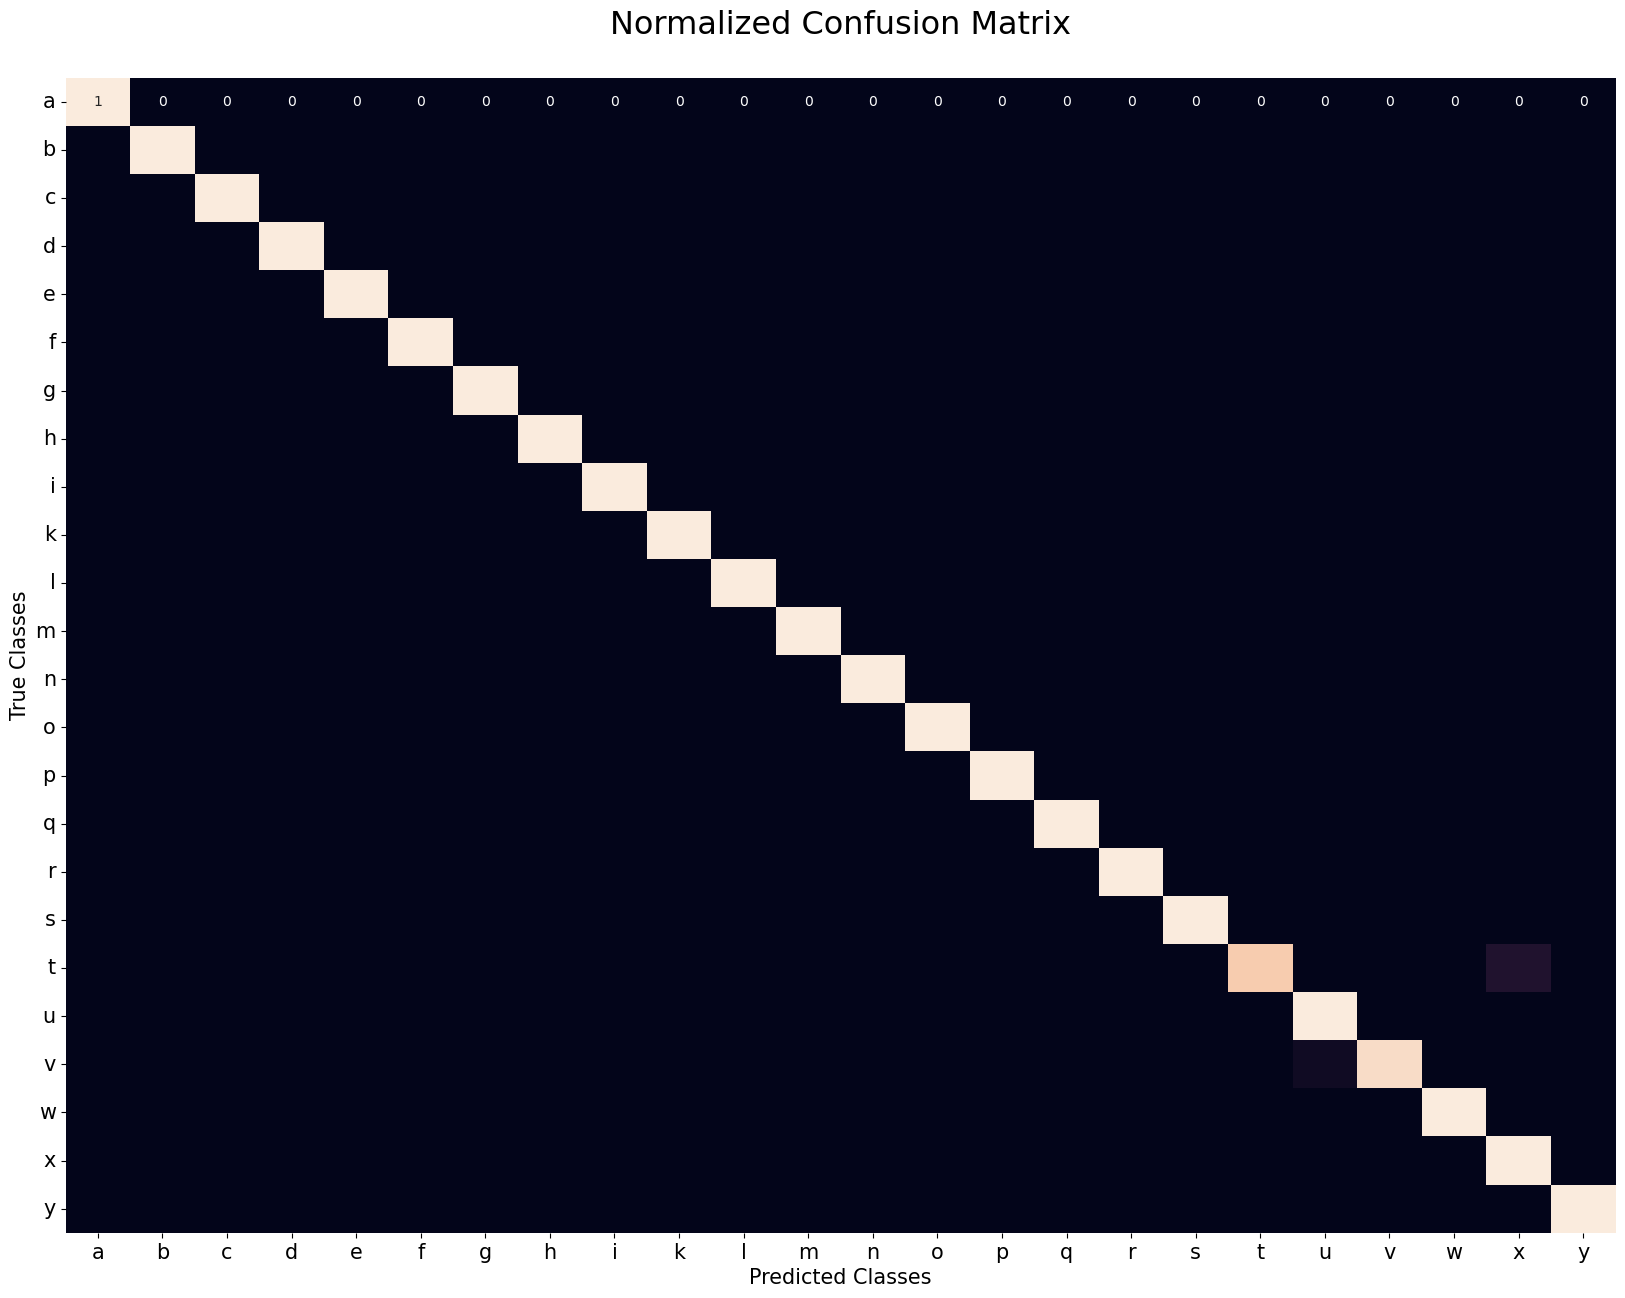

In [19]:
# Display a confusion matrix
cf_matrix = confusion_matrix(y_test_letters, pred_letters, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test_letters)), yticklabels = sorted(set(y_test_letters)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()

In [20]:
model_save_path = 'sign_language_model.h5'

model.save(model_save_path)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\khunt\AppData\Local\Temp\tmp7vka6i80\assets


INFO:tensorflow:Assets written to: C:\Users\khunt\AppData\Local\Temp\tmp7vka6i80\assets


3013792